In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd /content/drive/MyDrive/SARS-COV2-Classification/python

/content/drive/MyDrive/SARS-COV2-Classification/python


In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("labeled_protein_sequences.csv")
df.head()

,Sequence_ID,Protein_Sequence,Label
0,UIF27901.1,ITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFLYIIKLIF...,1
1,QJX19961.1,MAFSASLFKPVQLVPVSPAFHRIESTDSIVFTYIPASGYVAALAVN...,0
2,UMG10730.1,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLP...,1
3,ASU90795.1,MAFSASLFKPVQLVPVSPAFHRIESPDSIVFTYIPASGYVAALAVN...,0
4,UBU60787.1,MDLFMRIFTIGTVTLKQGEIKDATPLDFVRATATIPIQASLPFGWL...,1


In [5]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction import DictVectorizer

# Load protein sequences from CSV
df = pd.read_csv('labeled_protein_sequences.csv')  # Assumes 'Sequence' column

# Function to generate k-mers
def get_kmers(sequence, k=3):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Choose your k
k = 3

# Convert sequences to k-mer count dictionaries
kmers_dicts = [Counter(get_kmers(seq, k)) for seq in df["Protein_Sequence"]]

# Vectorize
vec = DictVectorizer(sparse=False)
X = vec.fit_transform(kmers_dicts)  # Feature matrix

# Save the feature vectors to .npy file
np.save('protein_kmer_features.npy', X)

print("Feature matrix shape:", X.shape)
print("Saved as 'protein_kmer_features.npy'")


Feature matrix shape: (17398, 7223)
Saved as 'protein_kmer_features.npy'


In [6]:
import os
print("File exists:", os.path.exists("protein_kmer_features.npy"))



File exists: True


In [7]:
import numpy as np

X = np.load("protein_kmer_features.npy")
print("Shape of X:", X.shape)

Shape of X: (17398, 7223)


In [8]:
df.shape

(17398, 3)

In [9]:
third_col = df.iloc[:, 2]

In [10]:
third_col.shape

(17398,)

In [11]:
third_col_array = third_col.to_numpy()

# Save to .npy file
np.save('labels.npy', third_col_array)

In [15]:
!pip install torch

   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.5/212.5 MB 882.6 kB/s eta 0:04:01
   ---------------------------------------- 0.8/212.5 MB 907.1 kB/s eta 0:03:54
   ---------------------------------------- 1.0/212.5 MB 1.0 MB/s eta 0:03:30
   ---------------------------------------- 1.3/212.5 MB 987.4 kB/s eta 0:03:34
   ---------------------------------------- 1.6/212.5 MB 1.0 MB/s eta 0:03:24
   ---------------------------------------- 2.1/212.5 MB 1.2 MB/s eta 0:02:58
   ---------------------------------------- 2.4/212.5 MB 1.2 MB/s eta 0:02:57
   ---------------------------------------- 2.6/212.5 MB 1.2 MB/s eta 0:02:56
    --------------------------------------- 2.9/212.5 MB 1.2 MB/s eta 0:02:49
    ----

In [16]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.metrics.pairwise import cosine_similarity

# Load preprocessed feature vectors
X = np.load('protein_kmer_features.npy')

# Load labels
df = pd.read_csv('labeled_protein_sequences.csv')
labels = df['Label'].values  # Make sure labels are 0 (Non-SARS) or 1 (SARS)

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(X)

# Create edges based on a threshold
threshold = 0.8  # You can experiment with 0.7, 0.85, etc.
edge_index = []

for i in range(similarity_matrix.shape[0]):
    for j in range(i+1, similarity_matrix.shape[0]):  # i+1 to avoid self-loop duplication
        if similarity_matrix[i, j] > threshold:
            edge_index.append([i, j])
            edge_index.append([j, i])  # Undirected graph: add both directions

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Node features
x = torch.tensor(X, dtype=torch.float)

# Node labels
y = torch.tensor(labels, dtype=torch.long)

# Create PyG Data object
data = Data(x=x, edge_index=edge_index, y=y)

print(data)


Data(x=[17398, 7223], edge_index=[2, 34498566], y=[17398])


In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader

# Assume you already have 'data' from Step 1

# Step 2.1: Split into Train and Test sets
# (80% training, 20% testing)

num_nodes = data.num_nodes
indices = torch.randperm(num_nodes)
train_size = int(0.8 * num_nodes)

train_idx = indices[:train_size]
test_idx = indices[train_size:]

# Step 2.2: Build GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Model setup
input_dim = data.num_node_features
hidden_dim = 64
output_dim = 2  # SARS (1) or Non-SARS (0)

model = GCN(input_dim, hidden_dim, output_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Step 2.3: Train the GCN
for epoch in range(1, 10):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# Step 2.4: Test the model
model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[test_idx].eq(data.y[test_idx]).sum().item())
accuracy = correct / len(test_idx)

print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1, Loss: 0.7677
Epoch 2, Loss: 0.0136
Epoch 3, Loss: 0.0120
Epoch 4, Loss: 0.0123
Epoch 5, Loss: 0.0118
Epoch 6, Loss: 0.0105
Epoch 7, Loss: 0.0084
Epoch 8, Loss: 0.0095
Epoch 9, Loss: 0.0067
Test Accuracy: 0.9994


In [19]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Generate confusion matrix
conf_matrix = confusion_matrix(data.y[test_idx].cpu().numpy(), pred[test_idx].cpu().numpy())
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision
precision = precision_score(data.y[test_idx].cpu().numpy(), pred[test_idx].cpu().numpy())
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(data.y[test_idx].cpu().numpy(), pred[test_idx].cpu().numpy())
print(f"Recall: {recall:.4f}")

Confusion Matrix:
[[1326    2]
 [   0 2152]]
Precision: 0.9991
Recall: 1.0000


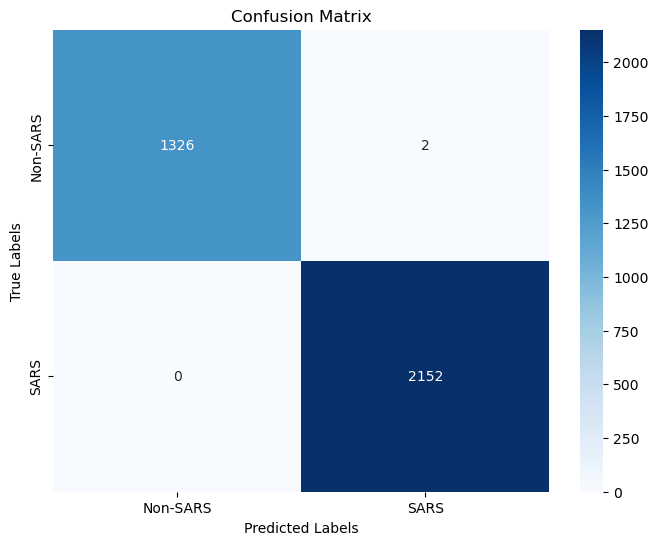

In [20]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-SARS', 'SARS'], yticklabels=['Non-SARS', 'SARS'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()